# Cyberbullying Detection Using NLP

## Data Loading

In [1]:
# Importing dataset via kaggle

!kaggle datasets download -d andrewmvd/cyberbullying-classification

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/2.82M [00:00<?, ?B/s]
100% 2.82M/2.82M [00:00<00:00, 40.4MB/s]


In [2]:
# Extracting data from zipfile

import zipfile
zip_ref = zipfile.ZipFile('cyberbullying-classification.zip', 'r')
zip_ref.extractall()
zip_ref.close()

## Exploratory Data Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
df  = pd.read_csv('cyberbullying_tweets.csv')

In [5]:
df  = df.head(20000)

In [6]:
df.shape

(20000, 2)

In [7]:
df.size

40000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          20000 non-null  object
 1   cyberbullying_type  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [9]:
df.describe().T

,count,unique,top,freq
tweet_text,20000,19915,"If we're at the bottom of the leaderboard, we'...",2
cyberbullying_type,20000,3,gender,7973


In [10]:
df.isnull().sum()

,0
tweet_text,0
cyberbullying_type,0


In [11]:
df.duplicated().sum()

33

In [12]:
df.nunique()

,0
tweet_text,19915
cyberbullying_type,3


In [13]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion'], dtype=object)

In [14]:
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
gender,7973
not_cyberbullying,7945
religion,4082


## Data Visualization

In [15]:
# Duplicating dataframe for data visualization

df_dv = df.copy()

In [17]:
# Labelling the dataframe

df_dv.rename(columns={'tweet_text': 'Text', 'cyberbullying_type': 'Label'}, inplace=True)

df_dv['Label'] = df_dv['Label'].replace({
    0: 'not_cyberbullying',
    1: 'gender',
    2: 'religion',
})

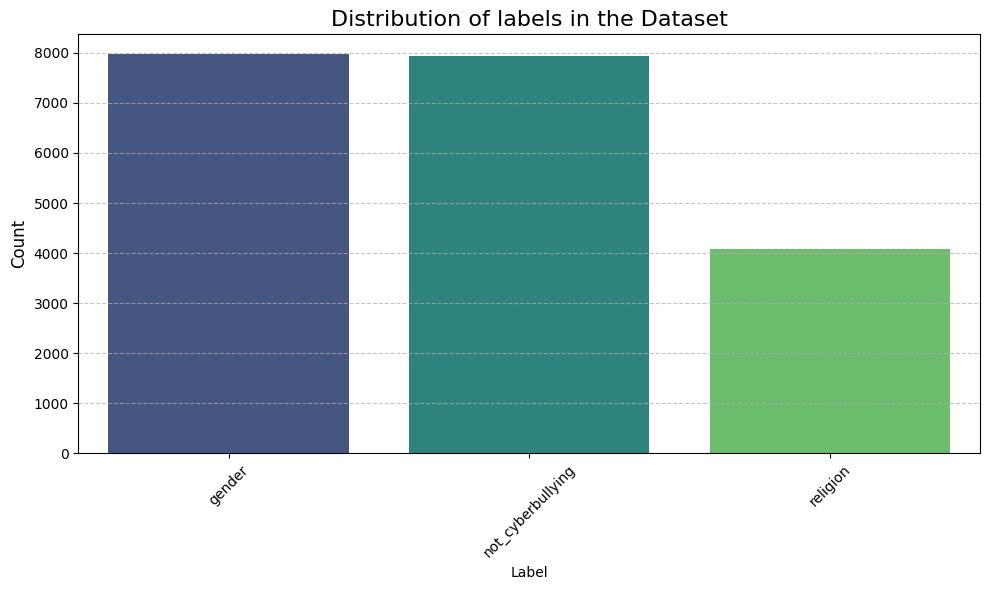

In [18]:
# Visualizing Distribution of Labels

label_counts = df_dv['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of labels in the Dataset', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

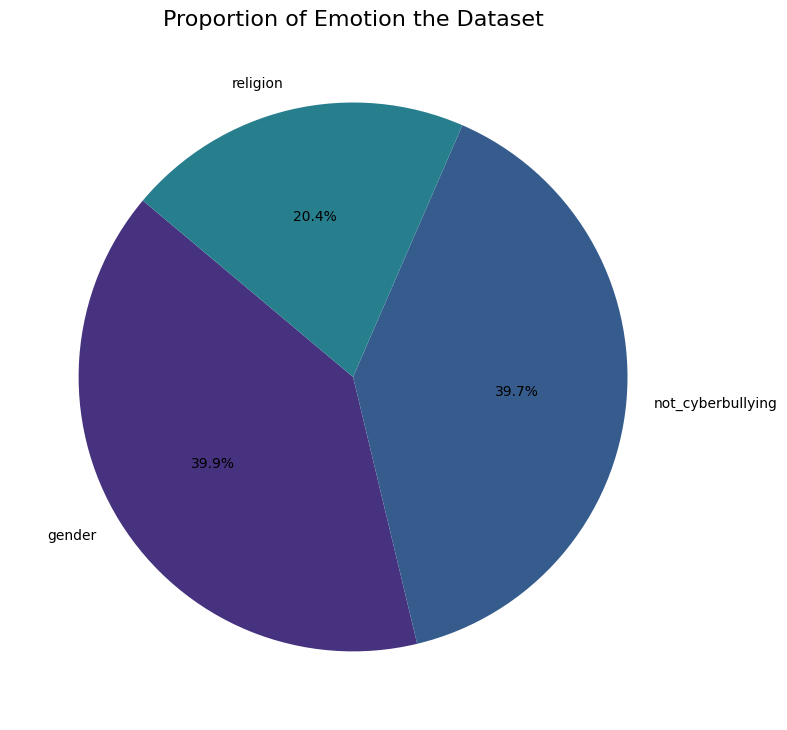

In [19]:
# Visualizing Label Distribution

plt.figure(figsize=(8, 8))

df_dv['Label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Proportion of Emotion the Dataset', fontsize=16)
plt.ylabel('')
plt.tight_layout()
plt.show()

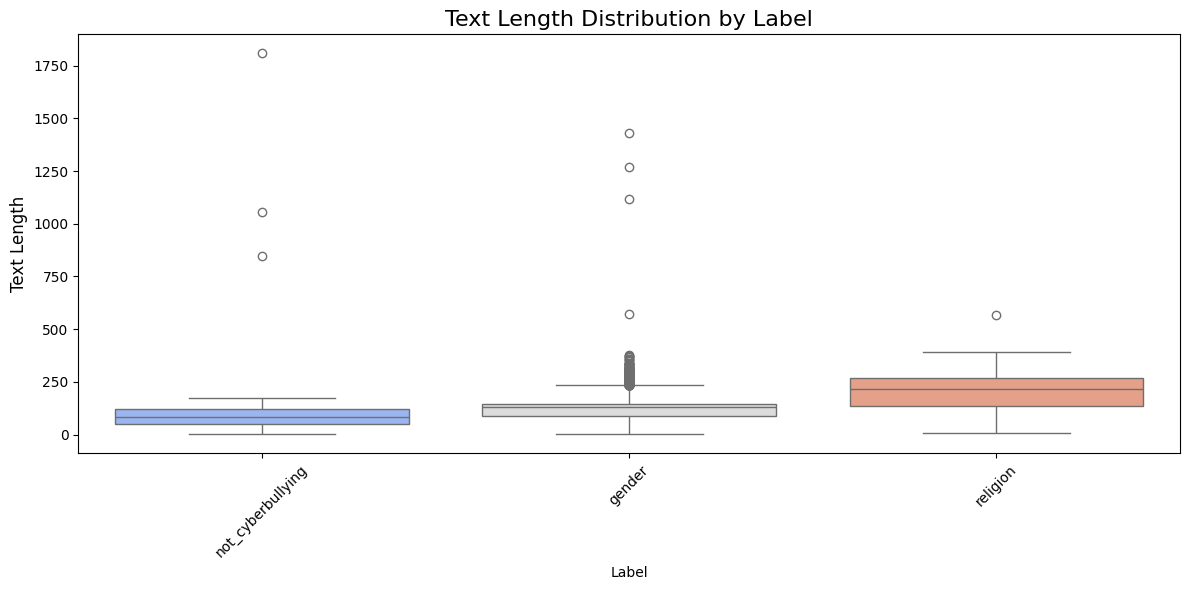

In [20]:
# Representing Text Length Distribution by Labels

df_dv['Text_Length'] = df_dv['Text'].astype(str).apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Text_Length', data=df_dv, palette='coolwarm')
plt.title('Text Length Distribution by Label', fontsize=16)
plt.ylabel('Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

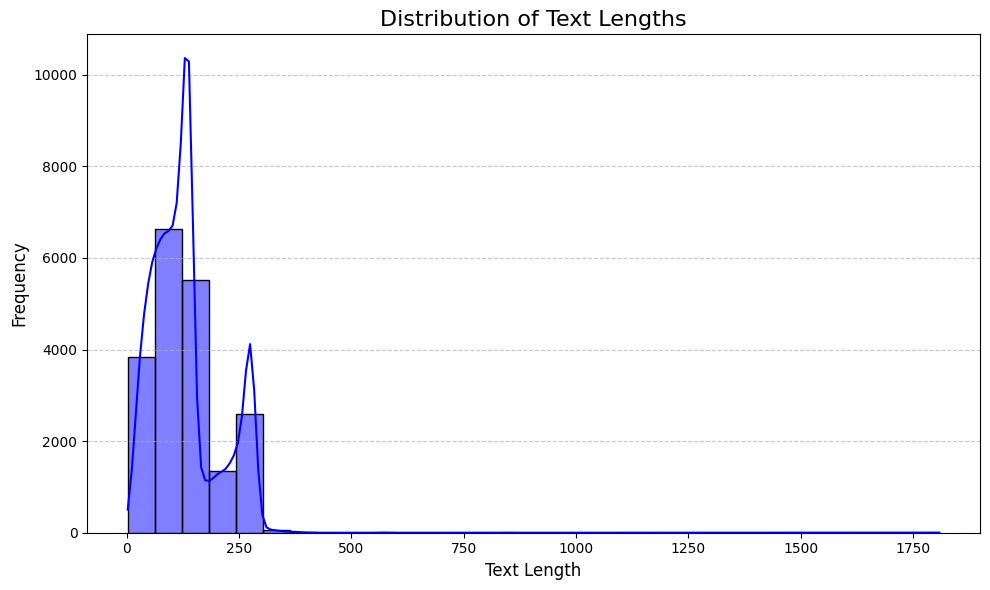

In [21]:
# Plotting Histogram for Distributon of Text Lengths

plt.figure(figsize=(10, 6))
df_dv['Text_Length'] = df_dv['Text'].astype(str).apply(len)
sns.histplot(df_dv['Text_Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

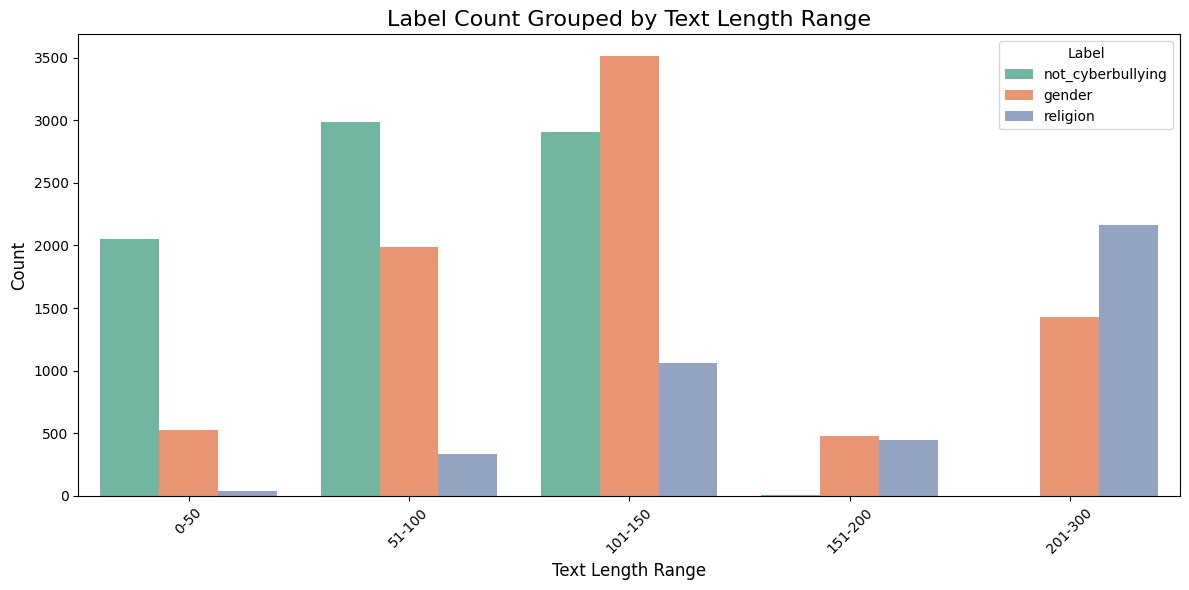

In [22]:
# Visualizing Label Count Grouped by Text Length Range

df_dv['Length_Bin'] = pd.cut(df_dv['Text_Length'], bins=[0, 50, 100, 150, 200, 300],
                          labels=['0-50', '51-100', '101-150', '151-200', '201-300'])

plt.figure(figsize=(12, 6))
sns.countplot(x='Length_Bin', hue='Label', data=df_dv, palette='Set2')
plt.title('Label Count Grouped by Text Length Range', fontsize=16)
plt.xlabel('Text Length Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

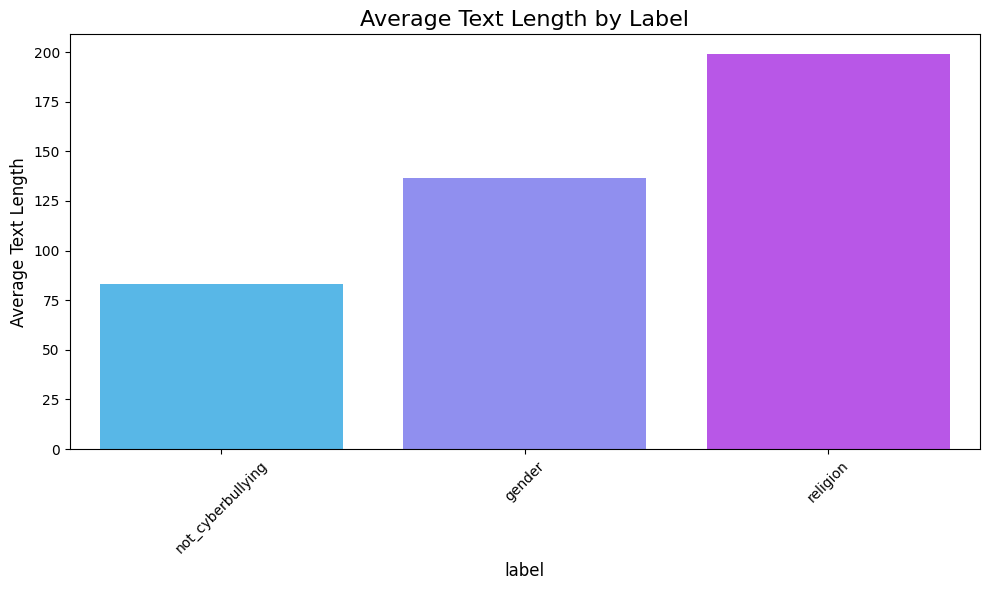

In [23]:
# Visualizing Average Text Length by label

avg_text_length = df_dv.groupby('Label')['Text_Length'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_text_length.index, y=avg_text_length.values, palette='cool')
plt.title('Average Text Length by Label', fontsize=16)
plt.xlabel('label', fontsize=12)
plt.ylabel('Average Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

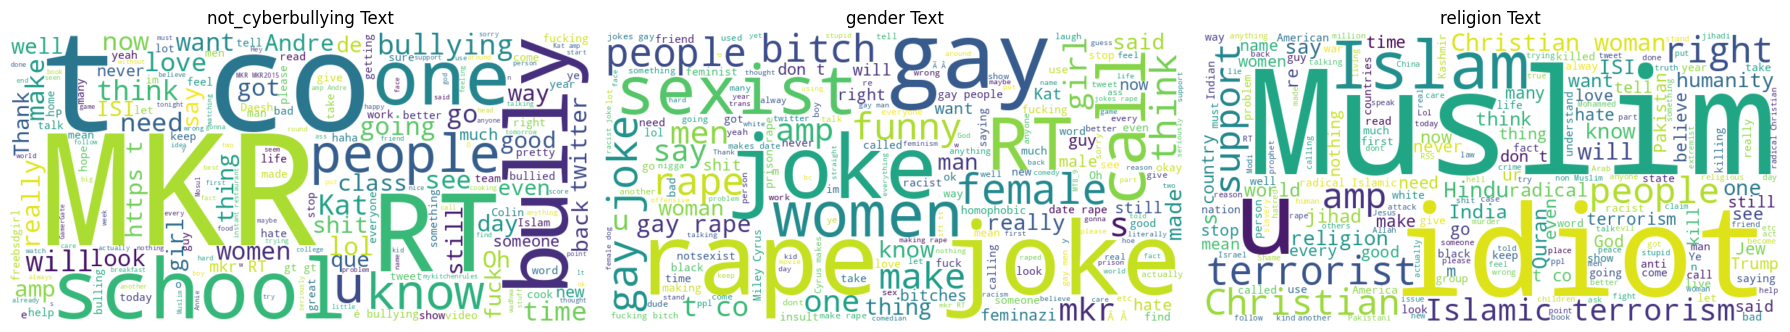

In [24]:
# Creating WordCloud for all the lables

from wordcloud import WordCloud

emotion_dfs = {
    'not_cyberbullying': df_dv[df_dv['Label'] == 'not_cyberbullying'],
    'gender': df_dv[df_dv['Label'] == 'gender'],
    'religion': df_dv[df_dv['Label'] == 'religion'],
}

plt.figure(figsize=(18, 12))  #
for i, (emotion, subset) in enumerate(emotion_dfs.items(), 1):
    combined_text = ' '.join(subset['Text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.subplot(3, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{emotion} Text')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [35]:
import re
import nltk
import sklearn
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [26]:
# Creating a pipeline for Data Cleaning

def clean_text_pipeline(df, text_column='tweet_text'):
    stop = set(stopwords.words('english'))

    def clean_text(text):

        text = str(text)
        text = re.sub(r'http\S+|www\S+|@\S+', '', text)  # Removing URLs and email addresses
        text = re.sub(r'[^\w\s]', '', text)        # Removing special characters and punctuation
        text = re.sub(r'\s+', ' ', text)           # Removing extra whitespaces
        text = text.lower()                        # Lowercasing text
        words = nltk.word_tokenize(text)           # Tokenization
        stemmer = PorterStemmer()                  # Stemmer
        words = [stemmer.stem(w) for w in words]
        return text

    df[text_column] = df[text_column].apply(clean_text)
    return df

In [27]:
# Data Cleaning

df = clean_text_pipeline(df, text_column='tweet_text')

In [28]:
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,not_cyberbullying
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying
2,a classy whore or more red velvet cupcakes,not_cyberbullying
3,meh p thanks for the heads up but not too con...,not_cyberbullying
4,this is an isis account pretending to be a ku...,not_cyberbullying


In [29]:
# Creating the Bag of Words model

cv = CountVectorizer()

X = cv.fit_transform(df['tweet_text']).toarray()
y = df['cyberbullying_type']

In [30]:
# Train Test and Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building & Prediction

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)

In [ ]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = clf.predict(X_test)
y_pred

array(['gender', 'not_cyberbullying', 'gender', ..., 'gender', 'gender',
       'gender'], dtype=object)

In [ ]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8995


#### SVM

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', max_iter=1000)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
y_pred

In [ ]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

#### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)

In [32]:
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [33]:
y_pred = clf.predict(X_test)
y_pred

array(['gender', 'not_cyberbullying', 'not_cyberbullying', ..., 'gender',
       'not_cyberbullying', 'gender'], dtype=object)

In [36]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.67625


#### MultinomialNB

In [37]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

In [38]:
clf.fit(X_train, y_train)

MultinomialNB()

In [39]:
y_pred = clf.predict(X_test)
y_pred

array(['gender', 'gender', 'gender', ..., 'gender', 'not_cyberbullying',
       'gender'], dtype='<U17')

In [40]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.831
